### Code 2: Figures and tables for publication

In [1]:
import numpy as np
import pandas as pd
from scipy.io import loadmat  # this is the SciPy module that loads mat-files
from datetime import datetime, date, time
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import cmasher as cmr

from mpl_toolkits.basemap import Basemap
pd.set_option('max_columns', None)
from netCDF4 import Dataset
from pathlib import Path
from dateutil.relativedelta import *

### [0] Load data

In [2]:
def LoadData():
    
    #[1] Select section 
    #Load multi-model weighted average data using CMA-ES optimization in MATLAB
    selection_file='Matlab_optimization_data'

    #[2] load data (KB_AVISO_ESM)
    m=loadmat('data/{}_raw.mat'.format(selection_file))

    #[3] Section information (KB_AVISO_ESM)
    ndata = {n: m['row'][n][0,0] for n in m['row'].dtype.names}
    dfm=pd.DataFrame.from_dict(dict((column, ndata[column][0]) for column in [n for n, v in ndata.items() if v.size == 1]))


    #[4] data (KB_AVISO_ESM)
    KB= m['KBCC2Q'][0]
    LCA=m['LCA'][0]
    LCM=m['LCM'][0]

    #[5] load data (weighted_ESM)
    m1=loadmat('data/{}_weighted.mat'.format(selection_file))

    #[6] Section information (weighted_ESM)
    Info=m1['SO_Info']
    columns=['idx','LC_AN', 'LC_MN', 'LCN_Match', 'Err_LCN','LC_AS', 'LC_MS', 'LCS_Match', 'Err_LCS','ecKBA', 'ecKBM', 'Err_ToT','RMSE']
    ridx=np.argmin(Info[:,-1], axis=0)
    dfmw=pd.DataFrame(data=Info[ridx:ridx+1,:],columns=columns)

    #[7] data (weighted_ESM)
    LCMW=m1['SO_MD'].mean(axis=0)


    #[9] Create dataframe with KB,AVISO,ESM and weight ESM data
    Q=pd.date_range('1993-01-01', periods=44, freq='2Q',closed='left')
    df = pd.DataFrame({'KB': KB, 'LCA': LCA, 'LCM': LCM,'LCMW':LCMW},index=Q)

    #[10] Display results
    Disp=0
    if Disp>0:
        display(dfm)
        display(dfmw)
        if Disp==2:
            display(df)
    return df,dfm,dfmw,KB,LCA,LCM,LCMW

### [1] Check seasonality invariance 
The error is the same for the first period (Jan-Jun) and second period (Jul-Dec)

In [3]:
#Seasonality error
[df,dfm,dfmw,KB,LCA,LCM,LCMW]=LoadData()
LCA=df['LCA'].to_numpy().reshape(22, 2)
LCM=df['LCM'].to_numpy().reshape(22, 2)
LCW=df['LCMW'].to_numpy().reshape(22, 2)


print('LC-N Simple average:',((LCA[:,0]>=0) & (LCM[:,0]>=0)).sum() + ((LCA[:,0]<0) & (LCM[:,0]<0)).sum())
print('LC-S Simple average:',((LCA[:,1]>=0) & (LCM[:,1]>=0)).sum() + ((LCA[:,1]<0) & (LCM[:,1]<0)).sum())


print('LC-N weighted average:',((LCA[:,0]>=0) & (LCW[:,0]>=0)).sum() + ((LCA[:,0]<0) & (LCW[:,0]<0)).sum())
print('LC-S weighted average:',((LCA[:,1]>=0) & (LCW[:,1]>=0)).sum() + ((LCA[:,1]<0) & (LCW[:,1]<0)).sum())

LC-N Simple average: 16
LC-S Simple average: 17
LC-N weighted average: 17
LC-S weighted average: 18


### [2] Figure1 reanalysis data

In [4]:
def zos_LoadData(np,Dataset,Path,df,nsim,disp_flag):
    
    #[1] Information of zos file (e.g., EC-Earth3P_hist-1950_r1i1p2f1.nc)
    path=('data/')
    file='{}_{}_{}.nc'.format(df.loc[nsim, 'Source_ID'],df.loc[nsim, 'Experiment_ID'],df.loc[nsim, 'Variant_Label'])
    realization=df.loc[nsim, 'Variant_Label']
    if disp_flag>0:
        print('{}: {}'.format(df.loc[nsim,'Institution_ID'],file))
    
    #[2] Read netCDF file
    #(2.1) Load netCDF file 
    data= Dataset(path+file,'r')  
    if disp_flag>1:
        print('reading netCDF file:')
        print(path+file)

        #(2.2) Read netCDF data infromation 
        #print "meta data for the dataset:"
        #print(data)
        #print('')
        print('List of variables:')
        print(data.variables.keys())
        print('')


    #[3] Read lat and lon data
    #(3.1) Name of lat and lon dimension variable 
    if df.loc[nsim,'lat_lon_grid']== 'no':
        lat_ID=df.loc[nsim,'lat_1d_ID']
        lon_ID=df.loc[nsim,'lon_1d_ID']
    else:
        lat_ID=df.loc[nsim,'lat_grid_ID']
        lon_ID=df.loc[nsim,'lon_grid_ID']
    
    #(3.2) Read lat and lon data from netCDF variables
    lats=data.variables[lat_ID][:]    #-89.5 to  89.5
    lons=data.variables[lon_ID][:]    #  0.5 to 359.
    if disp_flag>1:
        print('lats dimensions {}'.format(lats.shape))
        print('lons dimensions {}'.format(lons.shape))
        
        if disp_flag>2:
            print('native latitude coordinates:')
            if lats.ndim>1:
                print(lats[:,1])
            else:
                print(lats)
            print('')

            print('native longitude coordinates:')
            if lons.ndim>1:
                print(lons[1,:])
            else:
                print(lons)
            print('')

    #(3.3) lon conversion from 0:360 to 0:180E and 0:-180W with 0 greenwich prime meridian
    lons[:][lons[:]>180]-=360
    if disp_flag>2:
        print("Convert longitude '180:360' to '-180:0' if required:")
        if lons.ndim>1:
            print(lons[1,:])
        else:
            print(lons)
        print('')
        print('type of lats and lons data:', type(lons))


    #[4] Read zos data 
    #(4.1) Check variable information
    vnam='zos'
    var=data.variables[vnam]
    if disp_flag>2:
        print('Meta data for',vnam, 'variable:')
        print(var)
        print(var.units)
        print('')

    #(4.2) Extract raw zos data
    vval=var[:]
    if disp_flag==2:
        print('vval dimensions {}'.format(vval.shape))
    elif disp_flag>1:
        print('variable data information:')
        print('type : ', type(vval))
        print('ndim : ', vval.ndim)
        print('shape: ', vval.shape)
        print('size : ', vval.size)
        print('size : ', vval.min())
        print('size : ', vval.max())
        
    return lats,lons,vval,data,vnam

In [5]:
def zos_GeoPlot(np,Dataset,Path,date,relativedelta,ax,nsim,Start,title,Lim,cmap):
    
    #[0] General
    if Start<0:
        MFile=1
        Save=1
    else:
        MFile=0
        Save=0
        
    disp_flag=0
    Shading='gouraud' #none, flat, gouraud
    
    #[0]Variables 
    
    df=pd.read_csv('data/zos_models.csv')
    lat_lon_grid=df.loc[nsim, 'lat_lon_grid']
    Source_ID=df.loc[nsim,'Source_ID']
    Institution_ID=df.loc[nsim,'Institution_ID']
    Experiment_ID=df.loc[nsim,'Experiment_ID']
    Variant_Label=df.loc[nsim,'Variant_Label']

    #[1] load data
    lats,lons,vval,data,vnam=zos_LoadData(np,Dataset,Path,df,nsim,disp_flag)
    if disp_flag>1:
        print('vval dimensions {} with min,max=({},{})'.format(vval.shape,str(vval.min()),str(vval.max())))
        print('grid type: ' + lat_lon_grid)
    
    #[2] Select zos data period
    #Time range 199001 to 201412
    if MFile==0:
        End=Start+1
    elif MFile==1:
        Save=1
        period=[1993, 2015]
        start_date = date(period[0]-1, 12,30)
        Start=(period[0]-1993)*12
        End=Start+(period[1]-period[0])*12
        print(start_date,Start,End)
        
    #[3] Plot zos data
    for file in range(Start,End):

        #(3.1) Select Basemap
        #(3.2) Draw and label meridians (longitude lines) for values (in degrees) given in the sequence meridians
        #(3.3) Lon and lat data, and mesh grid 
        if lat_lon_grid == 'no':
            lon, lat= np.meshgrid(lons,lats) #Creat mesh grid
        else:
            lon,lat=lons,lats
        x,y=ax.map(lon,lat) #x, y coordiante
    
        #(3.4) Extract zos data
        val=vval[file,:,:]
        if MFile==1:
            start_date = start_date +relativedelta(months=+1)    
            if disp_flag>1:
                print('{}: vval[{},{},{}]'.format(start_date.strftime('%Y-%m'),file,vval.shape[1],vval.shape[2]))
                
        #(3.5) plot zos data
        if Source_ID== 'CESM1-CAM5-SE-HR':
            val[x==1e20]=np.nan
            val[y==-1]=np.nan
            x[x==1e20]=np.nan
            y[y==-1]=np.nan
            ax.map.pcolor(x,y,np.squeeze(val), cmap='jet',zorder=7) 
        elif Institution_ID== 'MPI-M':
            ax.map.pcolor(x,y,np.squeeze(val), cmap='jet',zorder=7) 
        else:
            ax.map.pcolormesh(x,y,np.squeeze(val), shading=Shading, cmap=cmap,zorder=10)   
           
        #(3.6) Colorbar
        clb=ax.map.colorbar(location='bottom', pad='10%')
        clb.ax.set_title('Sea surface height above geoid (zos) [m]',fontsize=14)

        
        #plt.clim(-0.91,0.86)
        #plt.clim(vval.min(),vval.max())
        plt.clim(Lim[0],Lim[1])
        
        #(3.7) Draw background 
        #(3.8) Title
        if MFile==1:
            title='{}_{}_{}_{} \n {} [{}] {}' \
                .format(Institution_ID,Source_ID,Experiment_ID,Variant_Label \
                        , data[vnam].long_name,data[vnam].units,start_date.strftime('%Y-%m'))     
        plt.title(title, pad=15,fontsize=16)
        
        #(3.9) Plot north segment 
        #(3.10) Plot south segment 

        #(3.11) Show or save map
        if Save==1:
            folder='Figures/Manuscript1/{}_{}_{}/'.format(Source_ID,Experiment_ID,Variant_Label)
            Path(folder).mkdir(parents=True, exist_ok=True)
            file=str(start_date.strftime('%Y-%m'))+'.jpg'
            plt.savefig(folder+file)
        
    return ax

B-300 (9,22) and B-300 (59,78) north and south segments with 14 and 20 cells, respectively


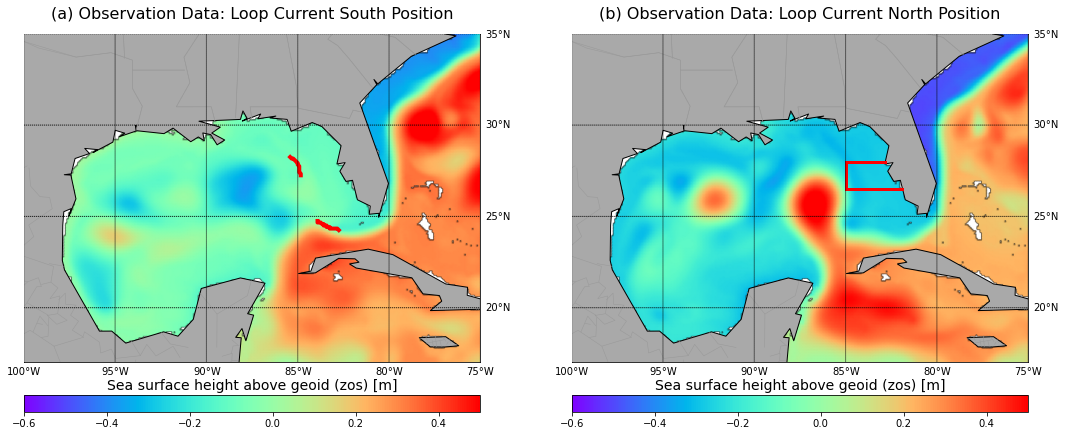

In [6]:
# [1] Load and display processed results
[df,dfm,dfmw,KB,LCA,LCM,LCMW]=LoadData()
#display(dfm)
NSeg=dfm['N'][0]; ns=dfm['Nstr'][0]; ne=dfm['Nend'][0];SSeg=dfm['S'][0]; ss=dfm['Sstr'][0]; se=dfm['Send'][0];
print('{} ({},{}) and {} ({},{}) north and south segments with {} and {} cells, respectively'. \
      format(NSeg,ns,ne,SSeg,ss,se,ne-ns+1,se-ss+1))

#[2] Create new figure
fig=plt.figure(figsize=(18,12))

#[3] Parameters per plot
Title=['(a) Observation Data: Loop Current South Position','(b) Observation Data: Loop Current North Position']
NFig=[1,2]
NStart=[70,60]       #S(70,212) N(18,60) 
Lim=[-0.6,0.5]
cmap='rainbow'  



#[4] Plot figurefor nfig,Start,title in zip(NFig,NStart,Title):
for nfig, Start,title in zip(NFig,NStart,Title):
    #(1) Create subplot
    ax=fig.add_subplot(1,2,nfig)
    ax.map =Basemap(projection='cyl', llcrnrlon=-100.0, llcrnrlat=17.0, urcrnrlon=-75.0, urcrnrlat=35.0)
    ax.map.drawmeridians(np.arange(10.,351.,5.) ,labels=[False,False,False,True],zorder=21)  
    ax.map.drawparallels(np.arange(0.,81,5.),labels=[False,True,False,False],zorder=22) 
    #ax.map.etopo(zorder=5)
    #ax.map.shadedrelief(zorder=5)
    ax.map.fillcontinents(color='darkgray',lake_color='aqua',zorder=11)
    #ax.map.drawrivers(color='b',zorder=12)
    ax.map.drawcoastlines(zorder=13)
    ax.map.drawstates(zorder=14,color='0.6')
    

    #(2) Plot segments 
    if nfig==1:
        data=np.loadtxt('data/{}.csv'.format(NSeg),delimiter=',')
        ax.map.plot(data[ns:ne,1], data[ns:ne,0], marker=None,color='r',linewidth=4,zorder=20)
        data=np.loadtxt('data/{}.csv'.format(SSeg),delimiter=',')
        ax.map.plot(data[ss:se,1], data[ss:se,0], marker=None,color='r',linewidth=4,zorder=20)
    
    #(4) Plot site area
    if nfig==2:
        ax.map.plot([-85.0,-85.0],[26.5,28.0], marker=None,color='r',linewidth=3,zorder=20)
        ax.map.plot([-85.0,-82.85],[28.0,28.0], marker=None,color='r',linewidth=3,zorder=20)
        ax.map.plot([-85.0,-81.9],[26.5,26.5], marker=None,color='r',linewidth=3,zorder=20)
    
    #(5) Plot zos
    #(22) CMIP6.obs4MIPs.CMEMS.AVISO-1-0.phy-001-031.r0.Omon.zos.gn (1 realization) [86]
    nsim=86;
    ax=zos_GeoPlot(np,Dataset,Path,date,relativedelta,ax,nsim,Start,title,Lim,cmap)


#[5] Display or save plot
Save=1
if Save==0:
    plt.show()
elif Save==1:
    plt.savefig('Figure1_AVISO _data.tif',bbox_inches='tight')

### [3] Figur2 LR_ESM and HR_ESM

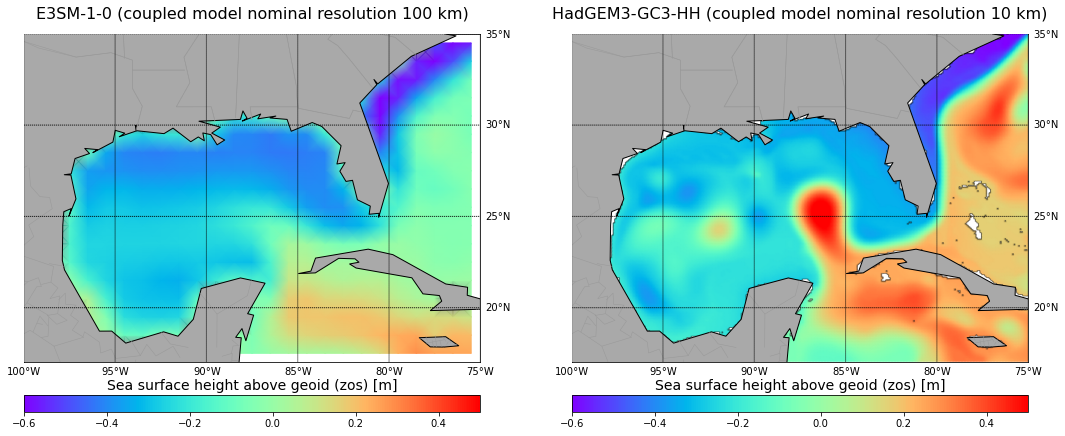

In [7]:
#[1] Load data
[df,dfm,dfmw,KB,LCA,LCM,LCMW]=LoadData()

#[2] Create new figure
fig=plt.figure(figsize=(18,12))

#[3] Parameters per plot
#Snap-shot 2010-03
Title=['E3SM-1-0 (coupled model nominal resolution 100 km)','HadGEM3-GC3-HH (coupled model nominal resolution 10 km)']
NFig=[1,2]
Start=240       
Lim=[-0.6,0.5]
cmap='rainbow'
#(7) CMIP6.CMIP.E3SM-Project.ES3M-1-0.historical.r1i1p1f1.Omon.zos.gr (5 realizations) [17]
#(14) CMIP6.HighResMIP.NERC.HadGEM3-GC31-HH.hist-1950.r1i1p1f1.Omon.zos.gn (1 realization) [49]
NSim=[17,49]

#[4] Plot figure
for nfig,nsim,title in zip(NFig,NSim,Title):
    
    #(1) Create subplot
    ax=fig.add_subplot(1,2,nfig)
    ax.map =Basemap(projection='cyl', llcrnrlon=-100.0, llcrnrlat=17.0, urcrnrlon=-75.0, urcrnrlat=35.0)
    ax.map.drawmeridians(np.arange(10.,351.,5.) ,labels=[False,False,False,True],zorder=21)  
    ax.map.drawparallels(np.arange(0.,81,5.),labels=[False,True,False,False],zorder=22) 
    #ax.map.etopo(zorder=5)
    #ax.map.shadedrelief(zorder=5)
    ax.map.fillcontinents(color='darkgray',lake_color='aqua',zorder=11)
    #ax.map.drawrivers(color='b',zorder=12)
    ax.map.drawcoastlines(zorder=13)
    ax.map.drawstates(zorder=14,color='0.6')
    
    
    #(5) Plot zos
    #(22) CMIP6.obs4MIPs.CMEMS.AVISO-1-0.phy-001-031.r0.Omon.zos.gn (1 realization) [86]
    ax=zos_GeoPlot(np,Dataset,Path,date,relativedelta,ax,nsim,Start,title,Lim,cmap)

plt.savefig('Figure2_SnapShot.tif',bbox_inches='tight')

### [4] Figure3 delta zos per period (AVISO,Model)

In [8]:
def plot_zos(df,Plot,Period,count,fig):
    
    #fig=plt.figure(figsize=(15,5))
    ax=fig.add_subplot(3,1,count+1)


    #[1] Data with colors
    y=df.KB
    cc=['colors']*len(y)
    for n,y_i in enumerate(y):
        if y_i>0:
            cc[n]='red'
        else:
            cc[n]='green'    

    mask_N= [c == 'red' for c in cc]
    x1=df.index.copy()[mask_N]
    y1=df[Plot].copy()[mask_N]

    mask_S= [c == 'green' for c in cc]
    x2=df.index.copy()[mask_S]
    y2=df[Plot].copy()[mask_S]


    #[2] Plot bar chart
    if Period=='Q':
        BarW=92
    elif Period=='2Q':
        BarW=181
    ax.bar(x1,y1*100,width=BarW,facecolor='red',  alpha=0.7, label='Large Bloom')
    ax.bar(x2,y2*100,width=BarW,facecolor='green', alpha=0.7, label='No Bloom')

    #[3] format the x-ticks and labels
    years = mdates.YearLocator()   # every year
    if Period=='Q':
        months = mdates.MonthLocator(bymonth=[1,4,7,10,13])  # every month
    elif Period=='2Q':
        months = mdates.MonthLocator(bymonth=[1,7,13])  # every month
    years_fmt = mdates.DateFormatter('%Y')
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(years_fmt)
    ax.xaxis.set_minor_locator(months)

    #[4] x-axis limit
    Start=1993
    End=2015
    start = datetime(year=Start, month=1, day=1, hour=0)
    end   = datetime(year=End, month=1, day=1, hour=0)
    ax.set_xlim(start,end)

    #[5] Axis labels
    #if Plot=='LCWM' or Plot=='LCM':
        #ax.set_xlabel('Periods')
    ax.set_ylabel('delta zos (cm)')

    #[6] Legend
    ax.legend(loc='best')

    #[7] Grid
    ax.grid(which='major', axis='x')

    #[8] Title
    if Plot=='LCA':
        Title='(a) Observation data'
    elif Plot=='LCM':
        Title='(b) HR-ESMs: Simple multi-model ensemble average'     
    elif Plot=='LCMW':
        Title='(c) HR-ESMs: Weighted multi-model ensemble average'
    ax.set_title(Title,fontsize=15)


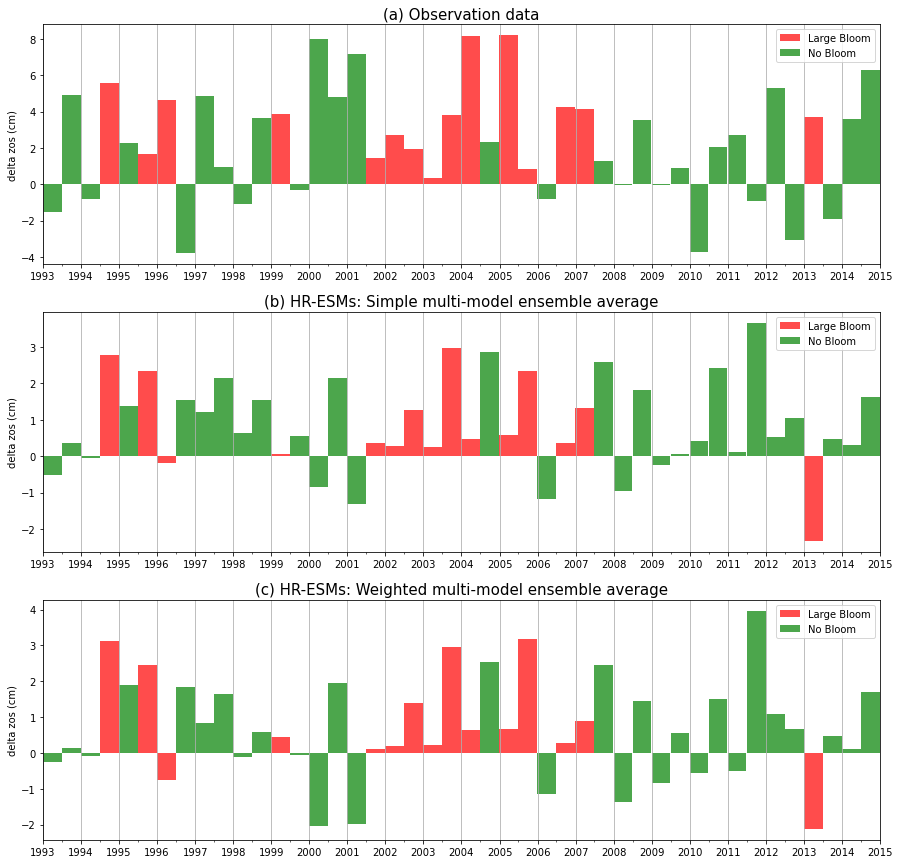

In [9]:
#[8] Plot bar_chart size 
[df,dfm,dfmw,KB,LCA,LCM,LCMW]=LoadData()
fig=plt.figure(figsize=(15,15))
Period='2Q';Save=1

for count,Plot in enumerate(['LCA','LCM','LCMW']):
    plot_zos(df,Plot,Period,count,fig)

#Display or save plot
if Save==0:
    plt.show()
elif Save==1:
    plt.savefig('Figure3_Data_ESMs.tif',bbox_inches='tight')

### [5] Table2 performance

In [10]:
#Code for best model
def Best_Model(dfm,loadmat,KB,res):
    
    #[0]General parameters
    NSeg=dfm['N'][0]; ns=dfm['Nstr'][0]; ne=dfm['Nend'][0];SSeg=dfm['S'][0]; ss=dfm['Sstr'][0]; se=dfm['Send'][0];
    model=dfm['model'][0]; KB_bloom=dfm['KB'][0]; Ensemble=dfm['Ensemble'][0]
    
    
    if KB_bloom[0]=='2':
        nm=6
    elif KB_bloom[0]=='Q':
        nm=3

    #[1] Load zos data of AVISO 
    zosAN=np.loadtxt('data/AVISO-1-1_phy-001-030_r0.csv',delimiter=',')
    zosAS=np.loadtxt('data/AVISO-1-1_phy-001-030_r0.csv',delimiter=',')
    
    #[3] Load zos data of model (raw data)
    zosMRN=np.load('data/{}.npy'.format(Ensemble))
    zosMRS=np.load('data/{}.npy'.format(Ensemble))    
    #print('Row({})-Ensemble({}): N {}({}:{}) from {} | S {}({}:{}) from {}'.\
    #      format(idx,Ensemble,NSeg,ns,ne,zosMRN.shape,SSeg,ss,se,zosMRS.shape))   
            
    #[6] Dataframe for results
    columns=['KB','LCN','LCS','LCN_NB','LCN_B','LCS_NB','LCS_B','Err_KB','Match_LCN',\
             'Match_LCS','Match_Tot','Err_LCN','Err_LCS','Err_Tot','RMSE']
    index=range(zosMRN.shape[0])
    BM = pd.DataFrame(columns = columns,index=index)

    #[7] zos model and AVISO data for selected section (for the average of selected ensemble from 1-9)
    for member in range(zosMRN.shape[0]):

        zosMN=zosMRN[member,:,:]
        zosMS=zosMRN[member,:,:]

        #(MSXP) mean_segment(delta-north-south), max_period
        DM=(np.nanmean(zosMN[:,ns:ne], axis=1) - np.nanmean(zosMS[:,ss:se], axis=1))
        LCM=DM.reshape((-1,nm),order='C').max(axis=1)
        DA=(np.nanmean(zosAN[:,ns:ne], axis=1) - np.nanmean(zosAS[:,ss:se], axis=1))
        LCA=DA.reshape((-1,nm),order='C').max(axis=1)
       
            
        #KB Blooms and LC counts
        BM.loc[member,'KB']=(KB>0).sum()
        BM.loc[member,'LCN']=(LCM>=0).sum()
        BM.loc[member,'LCS']=(LCM<0).sum()
        BM.loc[member,'LCN_NB']=((LCM>=0) & (KB==0)).sum()
        BM.loc[member,'LCN_B']=((LCM>=0) & (KB>0)).sum()
        BM.loc[member,'LCS_NB']=((LCM<0)  & (KB==0)).sum()
        BM.loc[member,'LCS_B']=((LCM<0)  & (KB>0)).sum()
        BM.loc[member,'Err_KB']= np.round(BM.loc[member,'LCS_B']/BM.loc[member,'KB'],decimals=3)

        #Temporal match between AVISO and model
        BM.loc[member,'Match_LCN']=((LCM>=0) & (LCA>=0)).sum()    
        BM.loc[member,'Match_LCS']=((LCM<0) & (LCA<0)).sum()  
        BM.loc[member,'Match_Tot']=BM.loc[member,'Match_LCN']+BM.loc[member,'Match_LCS']

        #Temporal error between AVISO and model     
        BM.loc[member,'Err_LCN']=np.round((res.loc['AVISO','LCN']-BM.loc[member,'Match_LCN'])/res.loc['AVISO','LCN'],decimals=3)
        BM.loc[member,'Err_LCS']=np.round((res.loc['AVISO','LCS']-BM.loc[member,'Match_LCS'])/res.loc['AVISO','LCS'],decimals=3)
        BM.loc[member,'Err_Tot']=np.round((len(LCA)-BM.loc[member,'Match_Tot'])/len(LCA),decimals=3)

        #RMSE between AVISO and model
        BM.loc[member,'RMSE']=np.round(np.sqrt(np.mean(np.square(LCM-LCA)))*1e2,decimals=2)
            
            
        
    return BM

In [11]:
#Code for LR_ESM : LR_ESM,LR_ESMDC(same as LR_ESM for double checking) ,LR_ESMW,E3SM
def LR_ESM(dfm,loadmat,member,WT):
    
    #[0]General parameters
    NSeg=dfm['N'][0]; ns=dfm['Nstr'][0]; ne=dfm['Nend'][0];
    SSeg=dfm['S'][0]; ss=dfm['Sstr'][0]; se=dfm['Send'][0];
    model=dfm['model'][0]; KB_bloom=dfm['KB'][0]; me=8
    Ensemble='NNNNN0'
    
    if KB_bloom[0]=='2':
        nm=6
    elif KB_bloom[0]=='Q':
        nm=3

    #[1] Load zos data of AVISO 
    zosAN=np.loadtxt('data/AVISO-1-1_phy-001-030_r0.csv',delimiter=',')
    zosAS=np.loadtxt('data/AVISO-1-1_phy-001-030_r0.csv',delimiter=',')
    
    #[2] Load zos data of model (Ensembe means)
    zosMN=np.load('data/Ensembles.npy')
    zosMS=np.load('data/Ensembles.npy')
    zosMN=zosMN[me,:,:] 
    zosMS=zosMS[me,:,:]
    
    #[3] Load zos data of model (raw data)
    zosMRN=np.load('data/{}.npy'.format(Ensemble))
    zosMRS=np.load('data/{}.npy'.format(Ensemble))    
    #print('Row({})-Ensemble({}): N {}({}:{}) from {} | S {}({}:{}) from {}'.\
    #      format(idx,Ensemble,NSeg,ns,ne,zosMRN.shape,SSeg,ss,se,zosMRS.shape))   
    
    #[4] Raw data for ESM_Weighted
    if member=='LR_ESMDC':
        zosMN=np.nanmean(zosMRN, axis=0)
        zosMS=np.nanmean(zosMRS, axis=0)
        #print(member,zosMN.shape,zosMS.shape)
    elif member=='LR_ESMW':
        zosMN=(np.nanmean(zosMRN[0:5,:,:], axis=0)*WT)+(np.nanmean(zosMRN[5:8,:,:], axis=0)*(1-WT))
        zosMS=(np.nanmean(zosMRN[0:5,:,:], axis=0)*WT)+(np.nanmean(zosMRN[5:8,:,:], axis=0)*(1-WT))
        #print(member,zosMN.shape,zosMS.shape)
    elif member=='E3SM':
        zosMN=np.nanmean(zosMRN[0:5,:,:], axis=0)
        zosMS=np.nanmean(zosMRS[0:5,:,:], axis=0)
        #print(member,zosMN.shape,zosMS.shape)
    elif member=='EC_Earth3P':
        zosMN=np.nanmean(zosMRN[5:8,:,:], axis=0)
        zosMS=np.nanmean(zosMRS[5:8,:,:], axis=0)
        #print(member,zosMN.shape,zosMS.shape)

    #[5] zos model and AVISO data for selected section (for the average of selected ensemble)
    #(MSXP) mean_segment(delta-north-south), max_period
    DM=(np.nanmean(zosMN[:,ns:ne], axis=1) - np.nanmean(zosMS[:,ss:se], axis=1))
    LCM=DM.reshape((-1,nm),order='C').max(axis=1)
    DA=(np.nanmean(zosAN[:,ns:ne], axis=1) - np.nanmean(zosAS[:,ss:se], axis=1))
    LCA=DA.reshape((-1,nm),order='C').max(axis=1)
    
    return LCM

In [12]:
#Code to process different ensembles 
def Process_Table1(dfm,loadmat,KB,res,member):
    
    #[1] Process results for best model (hase special code)
    #(10) CMIP6.HighResMIP.ECMWF.ECMWF-IFS-HR.hist-1950.r1i1p1f1.Omon.zos.gn (6 realizations) [Q 5]    0-5
    #(11) CMIP6.HighResMIP.ECMWF.ECMWF-IFS-MR.hist-1950.r1i1p1f1.Omon.zos.gn (3 realizations)[Q 5]     6-8
    #(14) CMIP6.HighResMIP.NERC.HadGEM3-GC31-HH.hist-1950.r1i1p1f1.Omon.zos.gn (1 realization)  [Q 5]  9
    #(15) CMIP6.HighResMIP.MOHC.HadGEM3-GC31-HM.hist-1950.r1i1p1f1.Omon.zos.gn (3 realizations) [Q 5]  10-12
    #(16) CMIP6.HighResMIP.MOHC.HadGEM3-GC31-MM.hist-1950.r1i1p1f1.Omon.zos.gn (3 realizations) [Q 5]  13-15
    #(17) CMIP6.CMIP.MOHC.HadGEM3-GC31-MM.historical.r1i1p1f3.Omon.zos.gn (4 realizations) [Q 5]       16-19
    if member=='Best_Model':
        BM=Best_Model(dfm,loadmat,KB,res)
        BM=BM[BM.Err_LCS == BM.Err_LCS.min()]
        BM=BM[BM.Err_KB == BM.Err_KB.min()]
        BM.index = 'Best_Model_' +  BM.index.astype(str)
        return BM
    
    #[2] Result table for  AVISO data,  HR_ESM , HR_ESMW
    columns=['KB','LCN','LCS','LCN_NB','LCN_B','LCS_NB','LCS_B','Err_KB',\
             'Match_LCN','Match_LCS','Match_Tot','Err_LCN','Err_LCS','Err_Tot','RMSE']
    resm = pd.DataFrame(columns = columns,index=[member])
    
    #[3] Estimate model weight for LR_ESMW
    if member=='LR_ESMW':
        WT=np.linspace(0,1,11)
        LR_W=pd.DataFrame(columns = columns)
    else:
        WT=[0.5]
    
    #[4] Process result AVISO, HR_ESM and LR_ESM members 
    for wt in WT:

        if member == 'AVISO':
            LC=LCA
        elif member == 'HR_ESM':
            LC=LCM
        elif member=='HR_ESMW':
            LC=LCMW
        elif member=='LR_ESM' or member=='LR_ESMDC' or member=='LR_ESMW'or member=='E3SM' or member=='EC_Earth3P':
            LC=LR_ESM(dfm,loadmat,member,wt)

        #KB Blooms and LC counts
        resm.loc[member,'KB']=(KB>0).sum()
        resm.loc[member,'LCN']=(LC>=0).sum()
        resm.loc[member,'LCS']=(LC<0).sum()
        resm.loc[member,'LCN_NB']=((LC>=0) & (KB==0)).sum()
        resm.loc[member,'LCN_B']=((LC>=0) & (KB>0)).sum()
        resm.loc[member,'LCS_NB']=((LC<0)  & (KB==0)).sum()
        resm.loc[member,'LCS_B']=((LC<0)  & (KB>0)).sum()
        resm.loc[member,'Err_KB']= np.round(resm.loc[member,'LCS_B']/resm.loc[member,'KB'],decimals=3)

        #Temporal match between AVISO and model
        resm.loc[member,'Match_LCN']=((LC>=0) & (LCA>=0)).sum()    
        resm.loc[member,'Match_LCS']=((LC<0) & (LCA<0)).sum()  
        resm.loc[member,'Match_Tot']=resm.loc[member,'Match_LCN']+resm.loc[member,'Match_LCS']

        #Temporal error between AVISO and model
        if member =='AVISO':
            resm.loc[member,'Err_LCN']=0
            resm.loc[member,'Err_LCS']=0
            resm.loc[member,'Err_Tot']=0
        else:
            resm.loc[member,'Err_LCN']=np.round((res.loc['AVISO','LCN']-resm.loc[member,'Match_LCN'])/res.loc['AVISO','LCN'],decimals=3)
            resm.loc[member,'Err_LCS']=np.round((res.loc['AVISO','LCS']-resm.loc[member,'Match_LCS'])/res.loc['AVISO','LCS'],decimals=3)
            resm.loc[member,'Err_Tot']=np.round((len(LCA)-resm.loc[member,'Match_Tot'])/len(LCA),decimals=3)

        #RMSE between AVISO and model
        resm.loc[member,'RMSE']=np.round(np.sqrt(np.mean(np.square(LC-LCA)))*1e2,decimals=2)

        #[2] Estimate model weight for LR_ESMW
        if member =='LR_ESMW':
            LR_W=LR_W.append(resm.loc['LR_ESMW',:])
            LR_W.rename(index={'LR_ESMW': 'LR_ESMW_{:.2f}'.format(wt)},inplace=True)

                
    #Select best model weight
    if member =='LR_ESMW':
        LR_W=LR_W[LR_W.Err_LCS == LR_W.Err_LCS.min()]
        LR_W=LR_W[LR_W.Err_KB == LR_W.Err_KB.min()]
        LR_W=LR_W[LR_W.RMSE == LR_W.RMSE.min()]
        resm=LR_W

    return resm 

In [13]:
#[1] Load data and display processed results
[df,dfm,dfmw,KB,LCA,LCM,LCMW]=LoadData()
#display(dfm); display(dfmw)

#{2] Process Table1
columns=['KB','LCN','LCS','LCN_NB','LCN_B','LCS_NB','LCS_B','Err_KB','Match_LCN','Match_LCS', \
         'Match_Tot','Err_LCN','Err_LCS','Err_Tot','RMSE']
res = pd.DataFrame(columns = columns)

#[3] Process members
members=['AVISO','HR_ESM','HR_ESMW','LR_ESM','LR_ESMW','E3SM','EC_Earth3P','Best_Model'] 
for member in members:
    res_member=Process_Table1(dfm,loadmat,KB,res,member)
    res=res.append(res_member)
    
#[3] Display results
display(res) 
res.to_csv('Table2.csv')

,KB,LCN,LCS,LCN_NB,LCN_B,LCS_NB,LCS_B,Err_KB,Match_LCN,Match_LCS,Match_Tot,Err_LCN,Err_LCS,Err_Tot,RMSE
AVISO,15,32,12,17,15,12,0,0,32,12,44,0,0,0,0
HR_ESM,15,35,9,22,13,7,2,0.133,28,5,33,0.125,0.583,0.25,3.68
HR_ESMW,15,31,13,18,13,11,2,0.133,27,8,35,0.156,0.333,0.205,3.81
LR_ESM,15,0,44,0,0,29,15,1,0,12,12,1,0,0.727,13.52
LR_ESMW_1.00,15,0,44,0,0,29,15,1,0,12,12,1,0,0.727,9.27
E3SM,15,0,44,0,0,29,15,1,0,12,12,1,0,0.727,9.27
EC_Earth3P,15,0,44,0,0,29,15,1,0,12,12,1,0,0.727,20.16
Best_Model_7,15,33,11,21,12,8,3,0.2,26,5,31,0.188,0.583,0.295,4.85
Best_Model_10,15,33,11,21,12,8,3,0.2,26,5,31,0.188,0.583,0.295,4.94
